# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

2024-12-12 01:04:40.318019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# SETUP DIRECTORIES AND LOAD METADATA 

In [2]:
metadata_path = "/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_metadata.csv"
img_dir_part1 = "/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_images_part_1"
img_dir_part2 = "/Users/apple/Documents/PROJECT RESEARCH/Dataset/HAMM 2/HAM10000_images_part_2"

# Load metadata
metadata = pd.read_csv(metadata_path)
metadata['image_id'] = metadata['image_id'].astype(str)

# Encode labels
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])

# Data Spliting & Loading Images Path

In [3]:
train_metadata, test_metadata = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)
train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.125, stratify=train_metadata['label'], random_state=42)

def load_image_paths(metadata, img_dir1, img_dir2):
    paths = []
    labels = []
    for idx, row in metadata.iterrows():
        img_name = row['image_id'] + '.jpg'
        label = row['label']
        img_path = os.path.join(img_dir1 if os.path.exists(os.path.join(img_dir1, img_name)) else img_dir2, img_name)
        paths.append(img_path)
        labels.append(label)
    return np.array(paths), np.array(labels)

# Load training, validation, and test data paths
train_paths, train_labels = load_image_paths(train_metadata, img_dir_part1, img_dir_part2)
val_paths, val_labels = load_image_paths(val_metadata, img_dir_part1, img_dir_part2)
test_paths, test_labels = load_image_paths(test_metadata, img_dir_part1, img_dir_part2)




# CLAHE - Image Enhancment 

In [4]:
def apply_clahe(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = apply_clahe(img)
    img = img / 255.0
    return img

# Data Generator Initializing

In [5]:
def data_generator(paths, labels, batch_size=32):
    while True:
        indices = np.arange(len(paths))
        np.random.shuffle(indices)
        for i in range(0, len(paths), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = np.array([preprocess_image(paths[i]) for i in batch_indices])
            batch_labels = labels[batch_indices]
            yield batch_images, tf.keras.utils.to_categorical(batch_labels, num_classes=len(np.unique(labels)))

# Model Building

In [6]:
def build_model(base_model):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(np.unique(train_labels)), activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

base_models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    'DenseNet121': DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    'EfficientNetB0': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
}

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Visualising Function

In [7]:
# Showcase that data is loaded correctly
def showcase_data_loading():
    print(f"Training dataset size: {len(train_paths)} images")
    print(f"Validation dataset size: {len(val_paths)} images")
    print(f"Test dataset size: {len(test_paths)} images")

    # Display sample images from the dataset
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(cv2.imread(train_paths[0]), cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Raw Image: {train_metadata.iloc[0]['image_id']}")
    axes[1].imshow(cv2.cvtColor(apply_clahe(cv2.imread(train_paths[0])), cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"CLAHE Image: {train_metadata.iloc[0]['image_id']}")
    axes[2].imshow(cv2.cvtColor(cv2.imread(train_paths[1]), cv2.COLOR_BGR2RGB))
    axes[2].set_title(f"Raw Image: {train_metadata.iloc[1]['image_id']}")
    plt.show()

# Preview - Raw Image vs CLAHE (Enhanced Image)

In [8]:
def preview_comparison():
    img_idx = 0  # You can change this to show different images
    raw_img = cv2.imread(train_paths[img_idx])
    clahe_img = apply_clahe(raw_img)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Raw Image", fontsize=16)
    axes[0].axis('off')
    axes[1].imshow(cv2.cvtColor(clahe_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title("CLAHE Image", fontsize=16)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()


# Confusion Matrix Analysis

In [9]:
# Confusion Matrix Visualization
def plot_confusion_matrix(cm, model_name):
    # Add more visual details to the confusion matrix plot
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cbar_kws={'label': 'Number of Samples'}, annot_kws={"size": 12})
    plt.title(f"Confusion Matrix: {model_name}", fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Model Training and Evaluating

In [10]:
def train_and_evaluate_model(model_name, base_model, epochs=30):
    print(f"\nTraining {model_name} model for {epochs} epochs...")
    model = build_model(base_model)

    # Train the model
    history = model.fit(
        data_generator(train_paths, train_labels, batch_size=32),
        steps_per_epoch=len(train_paths) // 32,
        validation_data=data_generator(val_paths, val_labels, batch_size=32),
        validation_steps=len(val_paths) // 32,
        epochs=epochs,
        callbacks=callbacks
    )

    # Preprocess test data
    test_images = np.array([preprocess_image(path) for path in test_paths])
    test_labels_cat = tf.keras.utils.to_categorical(test_labels, num_classes=len(np.unique(train_labels)))

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_images, test_labels_cat, verbose=0)
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

    # Generate predictions
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)

    # Display confusion matrix with enhanced visualization
    plot_confusion_matrix(cm, model_name)

    # Print confusion matrix summary
    correct_predictions = np.trace(cm)  # Sum of diagonal elements
    total_samples = np.sum(cm)
    misclassified_samples = total_samples - correct_predictions

    print(f"{model_name} Confusion Matrix Summary:")
    print(f"Correctly Classified Samples: {correct_predictions}")
    print(f"Misclassified Samples: {misclassified_samples}")

    # Compute precision, recall, and F1 score
    precision = precision_score(test_labels, predicted_labels, average='weighted')
    recall = recall_score(test_labels, predicted_labels, average='weighted')
    f1 = f1_score(test_labels, predicted_labels, average='weighted')

    # Print metrics
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {test_accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


# Main Execution - Centric Code

Training dataset size: 7010 images
Validation dataset size: 1002 images
Test dataset size: 2003 images


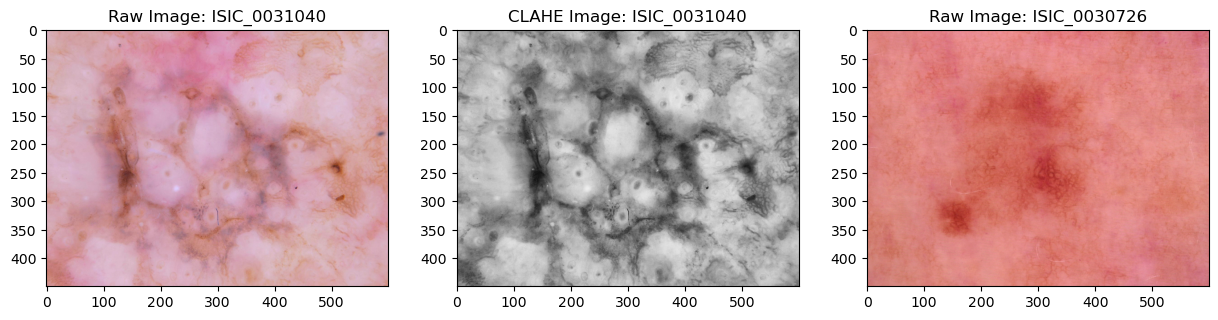

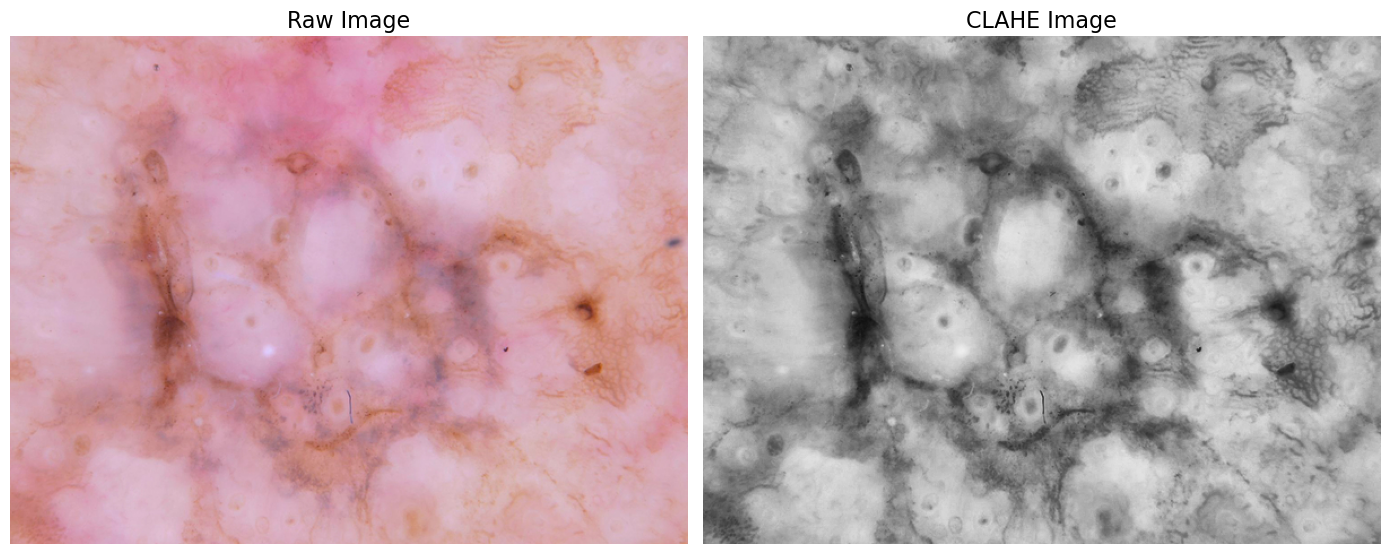


Training ResNet50 model for 30 epochs...
Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 653s 3s/step - accuracy: 0.5271 - loss: 1.6634 - val_accuracy: 0.6714 - val_loss: 4.7650
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 614s 3s/step - accuracy: 0.7182 - loss: 0.8425 - val_accuracy: 0.6660 - val_loss: 1.5433
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 662s 3s/step - accuracy: 0.7760 - loss: 0.6483 - val_accuracy: 0.3412 - val_loss: 1.6501
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 690s 3s/step - accuracy: 0.8169 - loss: 0.5151 - val_accuracy: 0.6732 - val_loss: 1.4519
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 690s 3s/step - accuracy: 0.8639 - loss: 0.3930 - val_accuracy: 0.7031 - val_loss: 1.7148
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 737s 3s/step - accuracy: 0.9221 - loss: 0.2365 - val_accuracy: 0.7299 - val_loss: 1.2759
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 663s 3s/step - accuracy: 0.9255 - loss: 0.2260 - val_accuracy: 0.7433 - val_loss: 1.8518
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 590s 3s/step - 

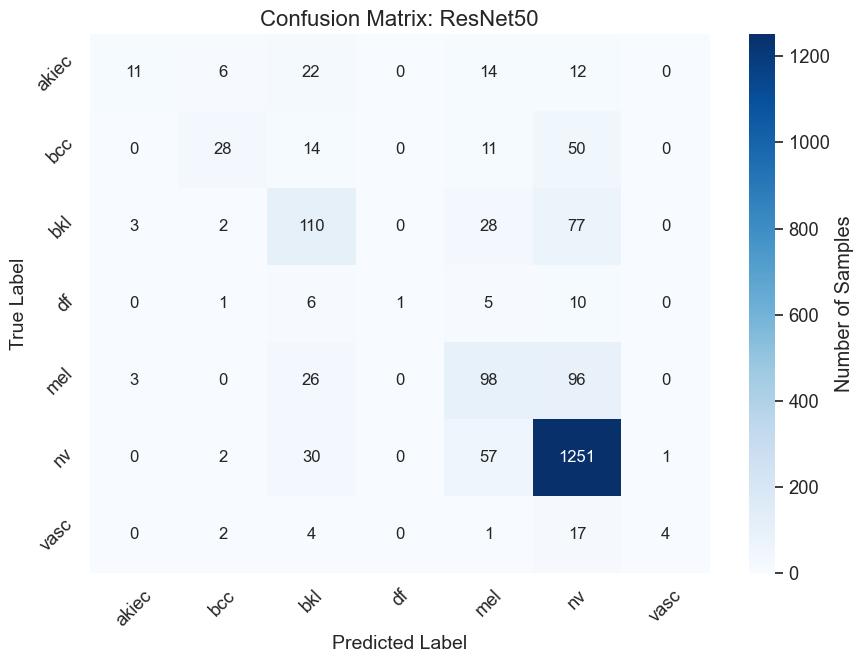

ResNet50 Confusion Matrix Summary:
Correctly Classified Samples: 1503
Misclassified Samples: 500
ResNet50 Metrics:
Accuracy: 0.75
Precision: 0.74
Recall: 0.75
F1 Score: 0.73

Training DenseNet121 model for 30 epochs...
Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 871s 4s/step - accuracy: 0.4222 - loss: 2.3110 - val_accuracy: 0.6754 - val_loss: 1.2075
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 867s 4s/step - accuracy: 0.6559 - loss: 1.0220 - val_accuracy: 0.6876 - val_loss: 0.8849
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 868s 4s/step - accuracy: 0.6993 - loss: 0.8453 - val_accuracy: 0.7165 - val_loss: 0.7692
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 869s 4s/step - accuracy: 0.7198 - loss: 0.7552 - val_accuracy: 0.7412 - val_loss: 0.7189
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 869s 4s/step - accuracy: 0.7670 - loss: 0.6467 - val_accuracy: 0.7268 - val_loss: 0.7458
DenseNet121 Test Accuracy: 67.15%
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 761ms/step


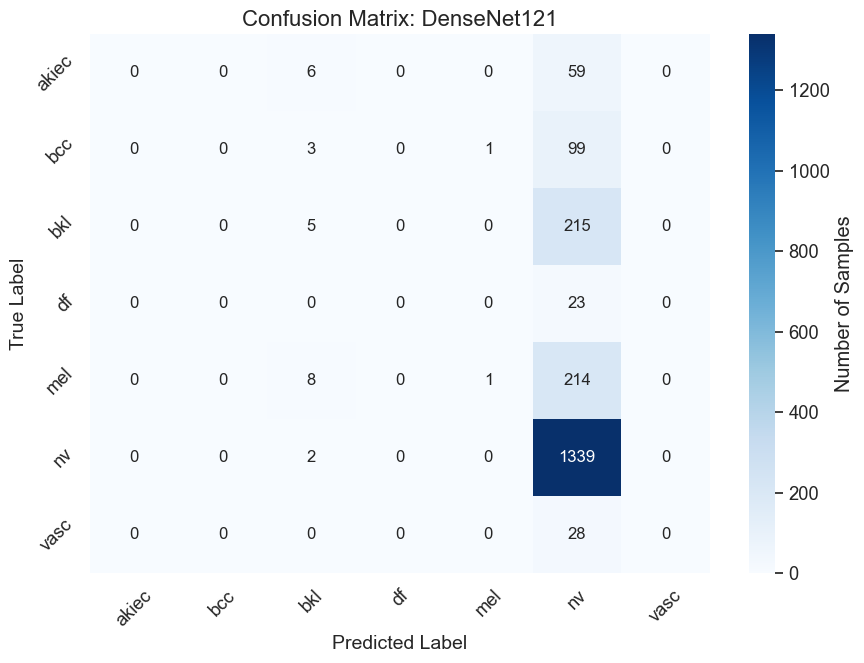

DenseNet121 Confusion Matrix Summary:
Correctly Classified Samples: 1345
Misclassified Samples: 658
DenseNet121 Metrics:
Accuracy: 0.67
Precision: 0.53
Recall: 0.67
F1 Score: 0.55

Training EfficientNetB0 model for 30 epochs...


/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.4839 - loss: 1.4946 - val_accuracy: 0.6694 - val_loss: 34.8141
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.6792 - loss: 0.9622 - val_accuracy: 0.6701 - val_loss: 1.2061
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.7247 - loss: 0.8188 - val_accuracy: 0.6052 - val_loss: 1.3405
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.7354 - loss: 0.7713 - val_accuracy: 0.6711 - val_loss: 1.3981
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.7653 - loss: 0.6707 - val_accuracy: 0.6608 - val_loss: 1.4430
EfficientNetB0 Test Accuracy: 66.95%
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 374ms/step


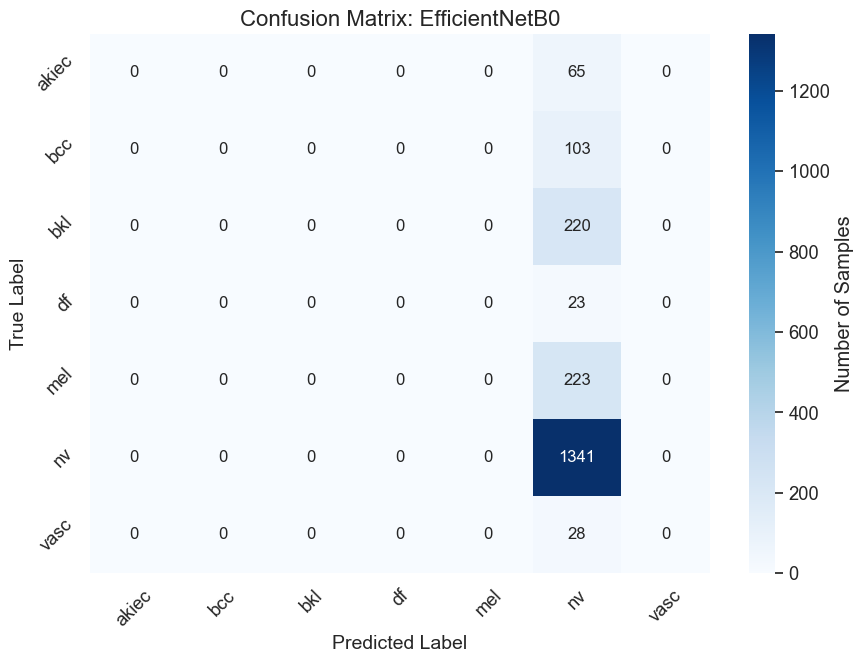

EfficientNetB0 Confusion Matrix Summary:
Correctly Classified Samples: 1341
Misclassified Samples: 662
EfficientNetB0 Metrics:
Accuracy: 0.67
Precision: 0.45
Recall: 0.67
F1 Score: 0.54


/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# Showcase that all the data is loaded
showcase_data_loading()

# Preview CLAHE vs Raw Images for the first few images
preview_comparison()

# Train and evaluate models with increased epochs
train_and_evaluate_model('ResNet50', base_models['ResNet50'], epochs=30)
train_and_evaluate_model('DenseNet121', base_models['DenseNet121'], epochs=30)
train_and_evaluate_model('EfficientNetB0', base_models['EfficientNetB0'], epochs=30)